<h1>目录<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#加载数据和模型" data-toc-modified-id="加载数据和模型-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>加载数据和模型</a></span></li><li><span><a href="#精度，召回率，F和时间随噪声的变化" data-toc-modified-id="精度，召回率，F和时间随噪声的变化-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>精度，召回率，F和时间随噪声的变化</a></span></li></ul></div>

In [1]:
%matplotlib inline
dataset = '01_industry'
raw_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/01_raw/'
label_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/04_ellipse_label/'
result_path = f'/home/liucc/Workspace/02_Ellipse/03_results/{dataset}/05_ellipse_result/proposed/'

In [2]:
import os 
fnames = os.listdir(raw_path)
fnames = [n[:-4] for n in fnames if n[-3:]=='jpg']
fnames.sort()
print(fnames[:10])

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010']


# 加载数据和模型

In [3]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/01_data')
from cc_process_image import *
import imageio

raws = get_all_images(f'{raw_path}',fnames,'jpg')

print(len(raws))

/home/liucc/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


66


In [4]:
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/01_cnn')
from cnn_model import *

model_path = r'/home/liucc/Workspace/02_Ellipse/06_model/'
model_name = r'ellipse'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = RestoreNet().to(device)

model.load_state_dict(torch.load(f'{model_path}{model_name}.mdl')['state_dict'])

In [5]:
gts = []

for name in fnames:
    lname = label_path+name+'.txt'
    
    with open(lname,'r') as f:
        txt = f.read()
        
        ells_t = [[float(v) for v in l.split(' ')] for l in txt.split('\n')]
        
        gts.append(ells_t)
        

print(len(gts))

66


# 精度，召回率，F和时间随噪声的变化

In [6]:
import sys
sys.path.append('/home/liucc/Workspace/02_Ellipse/02_algorithm/02_ellipse_detect')
from cc_ellipse import *
from experiment import *

In [7]:
import time
from skimage.feature import canny
#全局参数
GLOB = {
    'MIN_LEN' : 20,
    'MIN_COVER_ANGLE' : 150,
    'MIN_COVER_RHO1' : 0.5,
    'MIN_COVER_RHO2' : 0.2,
}

def one_task(raws,glob):
    start = time.time()

    prs = []
    
    pre_time = 0
    detect_time = 0
    
    for name,im in zip(fnames,raws):
        
        start = time.time()
        im = preprocess_image(im)
        imo = predict(model,im, device)
        end = time.time()
        
        pre_time+= end-start
        
        start = time.time()
        imo = postprocess_image(imo,thr=0.5)
        ells = detect_ellipses_im(imo,glob)
        end = time.time()
        
        detect_time+= end-start
        
        prs.append(ells)
    
    
    pre_time = pre_time/len(raws)
    detect_time = detect_time/len(raws)
    totat_time = pre_time+detect_time
    
    precision,recall,F1,_,_ = cal_metrics(prs,gts)
    
    return [precision,recall,F1,pre_time,detect_time,totat_time]

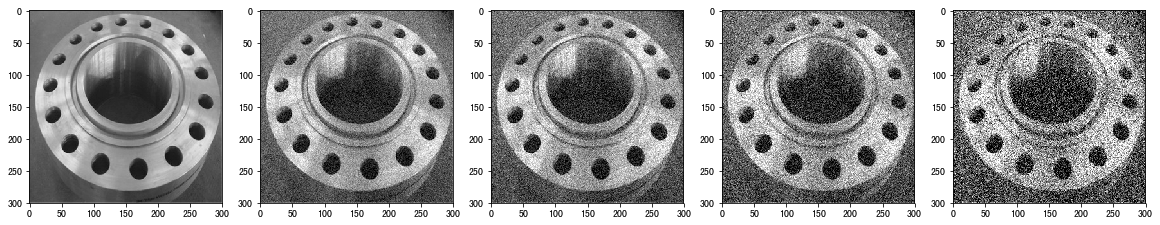

In [8]:
%matplotlib inline
from skimage.util import random_noise

gvars = [0,0.005,0.01,0.02,0.05] 
_,axes = plt.subplots(ncols=len(gvars),figsize=(20,10))

for ax,var in zip(axes,gvars):
    im = raws[4]
    im = random_noise(im,mode='gaussian',var=var)
    ax.imshow(im,cmap='gray',vmin=0,vmax=1)

In [9]:
pres = []
recs = []
F1s = []
for var in gvars: 
    
    graws = []
    for im in raws:
        graws.append(random_noise(im,mode='gaussian',var=var))
    
    precision,recall,F1,pre_time,detect_time,totat_time = one_task(graws,GLOB)
    
    pres.append(precision)
    recs.append(recall)
    F1s.append(F1)
           
    print('Precision:%.4f' % precision)
    print('Recall:   %.4f' % recall)
    print('F1 Score: %.4f' % F1)
    print('Process Time: %.0f' % (pre_time*1000))
    print('Detect Time: %.0f' % (detect_time*1000))
    print('Total Time: %.0f' % (totat_time*1000))
    print('')

Precision:0.8569
Recall:   0.6164
F1 Score: 0.7170
Process Time: 84
Detect Time: 264
Total Time: 348

Precision:0.8347
Recall:   0.5839
F1 Score: 0.6871
Process Time: 84
Detect Time: 258
Total Time: 342

Precision:0.8278
Recall:   0.5628
F1 Score: 0.6700
Process Time: 84
Detect Time: 252
Total Time: 336

Precision:0.8101
Recall:   0.5324
F1 Score: 0.6426
Process Time: 84
Detect Time: 243
Total Time: 328

Precision:0.7934
Recall:   0.4549
F1 Score: 0.5782
Process Time: 84
Detect Time: 229
Total Time: 313



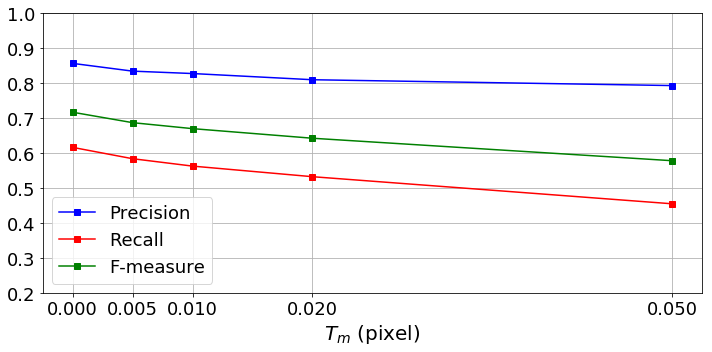

In [10]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.font_manager import FontProperties
fp1 = FontProperties(family="DejaVu Sans",size=20)
fp2 = FontProperties(family="DejaVu Sans",size=18)

fig = plt.figure(figsize=(10,5))

plt.plot(gvars,pres,'bs-',label='Precision')
plt.plot(gvars,recs,'rs-',label='Recall')
plt.plot(gvars,F1s,'gs-',label='F-measure')

plt.xlabel('$T_m$ (pixel)',fontproperties=fp1)
plt.xticks(gvars,fontproperties=fp2)
plt.yticks(fontproperties=fp2)
plt.legend(prop=fp2)
plt.ylim((0.2,1))
plt.grid()
plt.tight_layout()
plt.show()

pp = PdfPages('images/noise_compare.pdf')
pp.savefig(fig)
pp.close()